In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv


##  Part 1: Data Cleaning & Preprocessing


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')
df.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### 🧼 Handling Missing Values

In [4]:
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_df[missing_df['Missing Values'] > 0]

,Missing Values,Percentage
Sunshine,69835,48.009762
Evaporation,62790,43.166506
Cloud3pm,59358,40.807095
Cloud9am,55888,38.421559
Pressure9am,15065,10.356799
Pressure3pm,15028,10.331363
WindDir9am,10566,7.263853
WindGustDir,10326,7.098859
WindGustSpeed,10263,7.055548
Humidity3pm,4507,3.098446


# Drop columns with >30% missing values

In [5]:
df = df.drop(columns=missing_df[missing_df['Percentage'] > 30].index, errors='ignore')


# Fill missing values for numerical columns using the median

In [6]:

for column in df.select_dtypes(include=['float64', 'int64']):
    median_val = df[column].median()
    df[column].fillna(median_val, inplace=True)

# Fill missing values for categorical columns using the mode

In [7]:

for column in df.select_dtypes(include=['object']):
    mode_val = df[column].mode()[0]
    df[column].fillna(mode_val, inplace=True)

### Step 4: Duplicate Removal
# Remove duplicate rows to ensure data quality

In [8]:

initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f"Duplicates removed: {initial_shape[0] - df.shape[0]}")

Duplicates removed: 0


## Step 5: Outlier Detection using IQR Method


In [9]:

numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]


### Summary of Cleaning
# Reset index after removing rows

In [10]:
df.reset_index(drop=True, inplace=True)
print(f"Final dataset shape: {df.shape}")


Final dataset shape: (104811, 19)


In [11]:

# Save Cleaned Dataset 
df.to_csv("cleaned_weatherAUS.csv", index=False)

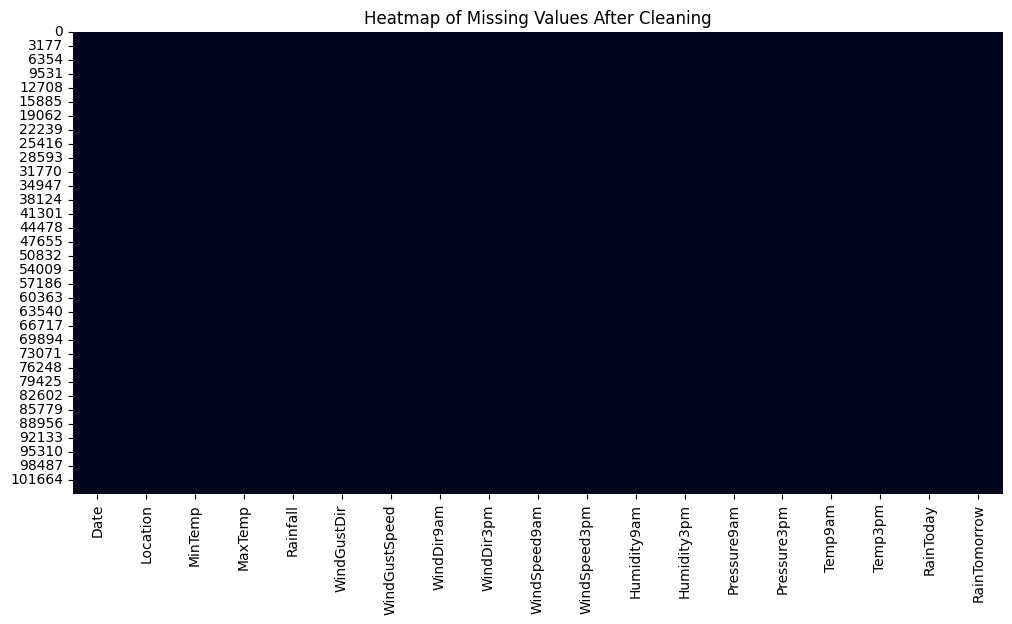

In [12]:
# Visualize missing values after cleaning if black it no missing value
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Heatmap of Missing Values After Cleaning")
plt.show()

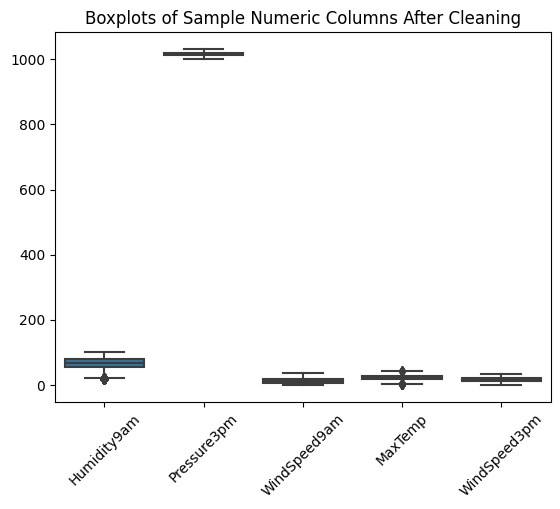

In [13]:
# Display boxplots for sample numeric columns to check for outliers
sns.boxplot(data=df[numeric_cols].sample(5, axis=1))
plt.title("Boxplots of Sample Numeric Columns After Cleaning")
plt.xticks(rotation=45)
plt.show()

### let do ML  Predict Next-Day Rain (RainTomorrow)


## Encode Categorical Features
# Convert categorical variables to numeric using Label Encoding

In [14]:

le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])



# Separate features and target variable, then split into training and test sets

In [15]:

X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#  Random Forest classifier to predict RainTomorrow

In [16]:

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# Predict on test data and evaluate model performance
y_pred = model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8816963220913038

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93     17855
           1       0.75      0.30      0.43      3108

    accuracy                           0.88     20963
   macro avg       0.82      0.64      0.68     20963
weighted avg       0.87      0.88      0.86     20963



## Plotting a Confusion Matrix

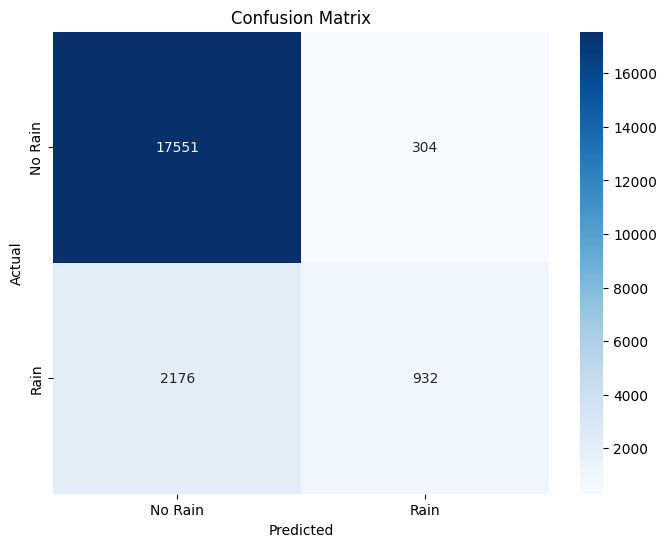

In [18]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Visualizing Predicted vs Actual Rain Predictions

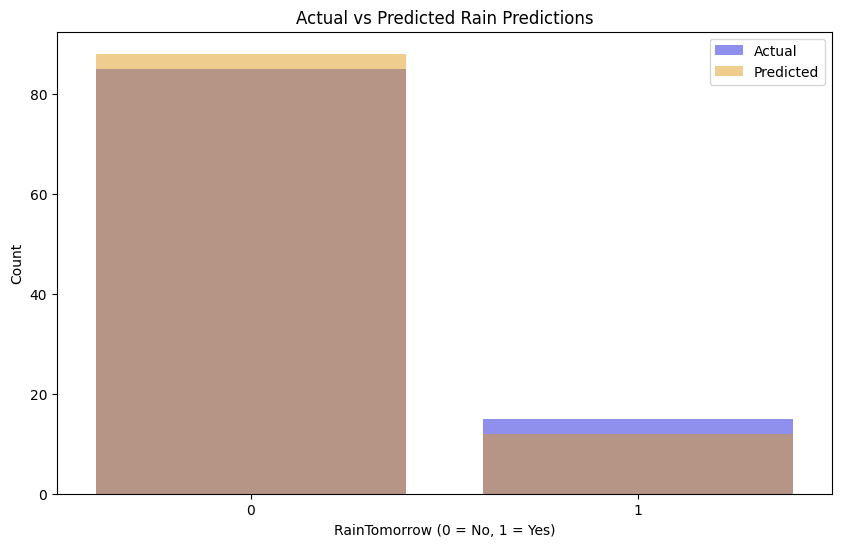

In [19]:

sample_size = 100
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)

true_values = y_test.iloc[sample_indices]
predicted_values = y_pred[sample_indices]

plt.figure(figsize=(10, 6))
sns.countplot(x=true_values, label='Actual', color='blue', alpha=0.5)
sns.countplot(x=predicted_values, label='Predicted', color='orange', alpha=0.5)

plt.title('Actual vs Predicted Rain Predictions')
plt.xlabel('RainTomorrow (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.legend()
plt.show()


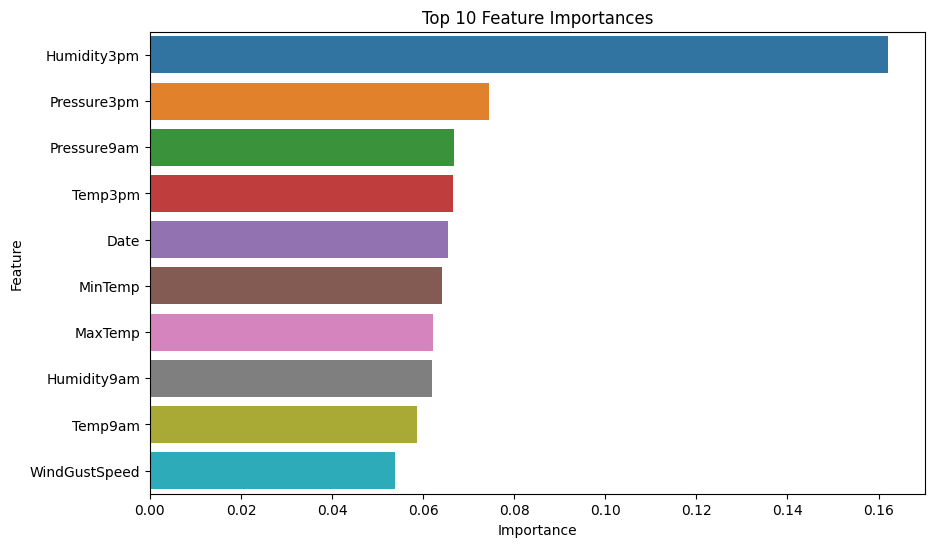

In [20]:
## Plotting the Feature Importances 


feature_importances = model.feature_importances_
features = X.columns

feature_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

 ## Visualizing Prediction Distribution

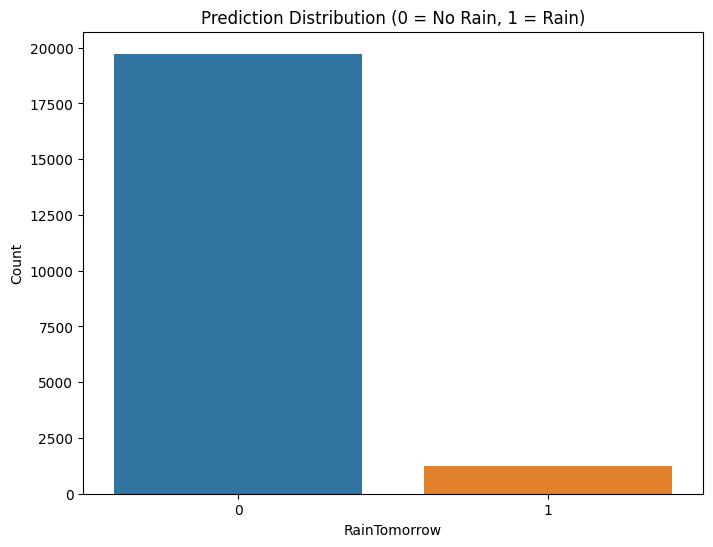

In [21]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred)
plt.title('Prediction Distribution (0 = No Rain, 1 = Rain)')
plt.xlabel('RainTomorrow')
plt.ylabel('Count')
plt.show()

Percentage of 'Rain' predictions: 5.90%
Percentage of 'No Rain' predictions: 94.10%


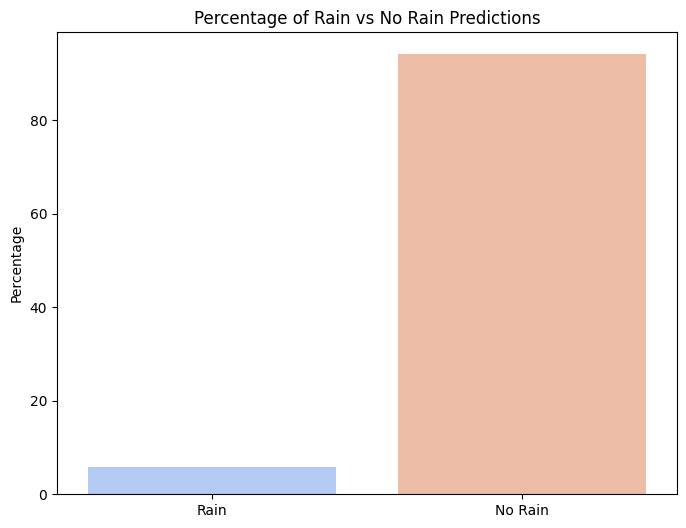

In [22]:

rain_count = np.sum(y_pred == 1)  
no_rain_count = np.sum(y_pred == 0)  

rain_percentage = (rain_count / len(y_pred)) * 100
no_rain_percentage = (no_rain_count / len(y_pred)) * 100

print(f"Percentage of 'Rain' predictions: {rain_percentage:.2f}%")
print(f"Percentage of 'No Rain' predictions: {no_rain_percentage:.2f}%")

plt.figure(figsize=(8, 6))
sns.barplot(x=['Rain', 'No Rain'], y=[rain_percentage, no_rain_percentage], palette='coolwarm')
plt.title('Percentage of Rain vs No Rain Predictions')
plt.ylabel('Percentage')
plt.show()
